In [1]:
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.units import units
from netCDF4 import num2date
import numpy as np
import scipy.ndimage as ndimage
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import metpy.calc as mpcalc

C:\Users\Tony\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

In [3]:
catalog_url = 'https://thredds-test.unidata.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml'
dataset_name = 'Best GFS Quarter Degree Forecast Time Series'
cat = TDSCatalog(catalog_url)
dataset = cat.datasets[dataset_name]
ncss = dataset.subset()
query = ncss.query()
query.lonlat_box(north=60, south=20, east=-55, west=-140).time(datetime.utcnow() + timedelta(hours=117))
query.accept('netcdf4')
print(ncss.variables)

query.variables('Temperature_isobaric','Geopotential_height_isobaric', 'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
query.vertical_level(50000)

data = ncss.get_data(query)

temp_var = data.variables['Temperature_isobaric']
gph_var = data.variables['Geopotential_height_isobaric']
u_wind_var500 = data.variables['u-component_of_wind_isobaric'][:] * units('m/s')
v_wind_var500 = data.variables['v-component_of_wind_isobaric'][:] * units('m/s')
time_var = data.variables[find_time_var(temp_var)]
lat_var = data.variables['latitude']
lon_var = data.variables['longitude']

temp = temp_var[:].squeeze()
lat = lat_var[:].squeeze()
lon = lon_var[:].squeeze()
gph_var = gph_var[:].squeeze()
u_wind500 = u_wind_var500[:].squeeze()
v_wind500 = v_wind_var500[:].squeeze()

temp = units.Quantity(temp, 'kelvin')
temp = temp.to('degC')

u_wind500 = units.Quantity(u_wind500, 'm/s')
v_wind500 = units.Quantity(v_wind500, 'm/s')

wnd = mpcalc.wind_speed(u_wind500, v_wind500)
wnd = wnd.to('kt')

time = num2date(time_var[:].squeeze(), time_var.units)
lon_2d, lat_2d = np.meshgrid(lon, lat)

{'Cloud_water_entire_atmosphere_single_layer', 'Visibility_surface', 'Geopotential_height_surface', 'Temperature_potential_vorticity_surface', 'Composite_reflectivity_entire_atmosphere', 'v-component_of_wind_pressure_difference_layer', 'Temperature_sigma', 'Pressure_high_cloud_bottom_Mixed_intervals_Average', 'Upward_Short-Wave_Radiation_Flux_atmosphere_top_Mixed_intervals_Average', 'Liquid_Volumetric_Soil_Moisture_non_Frozen_depth_below_surface_layer', 'Categorical_Snow_surface_Mixed_intervals_Average', 'Upward_Long-Wave_Radp_Flux_atmosphere_top_Mixed_intervals_Average', 'v-component_of_wind_tropopause', 'Water_runoff_surface_Mixed_intervals_Accumulation', 'Maximum_temperature_height_above_ground_Mixed_intervals_Maximum', 'Medium_cloud_cover_middle_cloud_Mixed_intervals_Average', 'u-component_of_wind_tropopause', 'Pressure_height_above_ground', 'Ice_temperature_surface', 'Absolute_vorticity_isobaric', 'Categorical_Snow_surface', 'u-component_of_wind_isobaric', 'Relative_humidity_sigma

In [4]:
vor = mpcalc.vorticity(u_wind500.to('kt'), v_wind500.to('kt'), dx=13e3*units.meters, dy=13e3*units.meters)
vor = ndimage.gaussian_filter(vor, sigma=1, order=0)
gph = ndimage.gaussian_filter(gph_var, sigma=2, order=0)

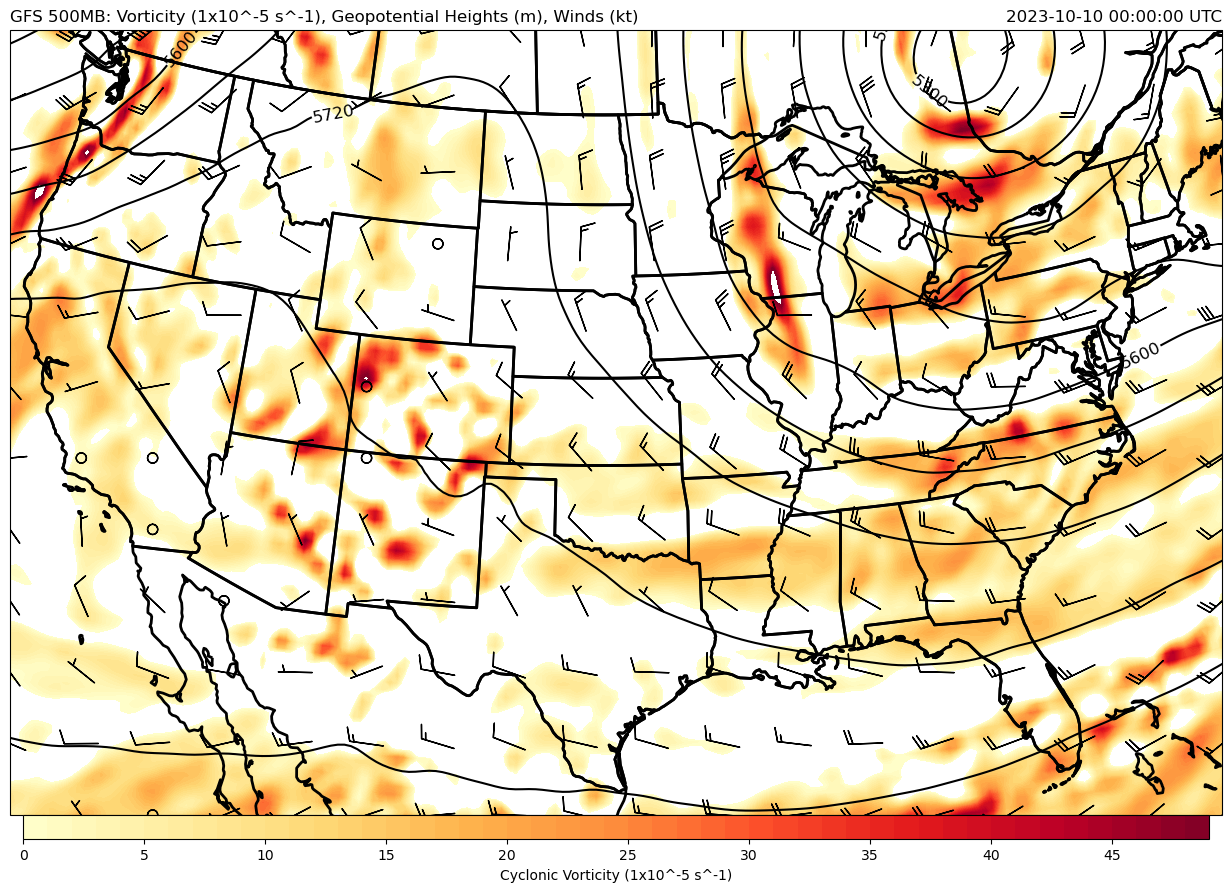

In [5]:
mapcrs = ccrs.LambertConformal(central_longitude=-98, central_latitude=39)  
datacrs = ccrs.PlateCarree() 
fig = plt.figure(figsize=(18,12)) 
ax = fig.add_subplot(1, 1, 1, projection=mapcrs) 
  
ax.set_extent([-120, -75, 25, 50], datacrs) 

ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=2)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=2)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black', linewidth=2)

cf = ax.contour(lon_2d, lat_2d, gph, range(5000, 6000, 60), colors='black', transform=datacrs)
ax.clabel(cf, fontsize=12, inline=1, inline_spacing=4, fmt='%i')

cf = ax.contourf(lon_2d, lat_2d, vor*1e5, range(0, 50, 1), cmap=plt.cm.YlOrRd,
                 transform=datacrs)
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, label = 'Cyclonic Vorticity (1x10^-5 s^-1)', shrink=.85)

ax.barbs(lon_2d, lat_2d, u_wind500.m, v_wind500.m, pivot='middle', color='black', regrid_shape=12, transform=datacrs, zorder=2)
plt.title('GFS 500MB: Vorticity (1x10^-5 s^-1), Geopotential Heights (m), Winds (kt)', loc='left')
plt.title('{:s} UTC'.format(str(time)), loc='right')
plt.show()